In [144]:
file_dir = "../results/detections/test_results.mat"
import scipy.io as sio

mat_data = sio.loadmat(file_dir)


mat_data



{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Wed May 14 02:09:44 2025',
 '__version__': '1.0',
 '__globals__': [],
 'BD': array([[   1,  985, 1071,  808,  914,    7],
        [   2,  852,  916,  174,  251,    6],
        [   2,  384,  449,  404,  473,    4],
        ...,
        [ 259, 1139, 1200,  771,  895,    7],
        [ 260,  278,  370,  879,  964,   10],
        [ 260,  278,  370,  879,  964,   10]])}

In [222]:
# -*- coding: utf-8 -*-
"""
Created on Sun May  4 11:49:42 2025

@author: fross
"""

import numpy as np
import scipy.io
import logging
from typing import Dict, Tuple, Any

def evaluation(BDREF_path, BDTEST_path, resize_factor):
    try:
        BDREF = scipy.io.loadmat(BDREF_path)['BD']
        BDTEST = scipy.io.loadmat(BDTEST_path)['BD']
    except Exception as e:
        return None
    
    BDTEST[:, 1:5] = resize_factor * BDTEST[:, 1:5]
    
    I = np.mean(BDREF[:, 1:3], axis=1)
    J = np.mean(BDREF[:, 3:5], axis=1)
    D = np.round((BDREF[:, 2] - BDREF[:, 1] + BDREF[:, 4] - BDREF[:, 3]) / 2)
    maxDecPer = 0.1
    
    confusionMatrix = np.zeros((14, 14), dtype=int)
    plusVector = np.zeros(14, dtype=int)   
    minusVector = np.zeros(14, dtype=int)   
    processed = np.zeros(BDREF.shape[0], dtype=bool)
    
    for k in range(BDTEST.shape[0]):
        n = BDTEST[k, 0] 
        ind = np.where(BDREF[:, 0] == n)[0]  
        
        i = np.mean(BDTEST[k, 1:3])
        j = np.mean(BDTEST[k, 3:5])
        
        d = np.sqrt((I[ind] - i) ** 2 + (J[ind] - j) ** 2)
        
        if len(d) > 0:
            mind = np.min(d)
            p = np.argmin(d)
            kref = ind[p]
            
            if mind <= maxDecPer * D[kref]:
                confusionMatrix[int(BDREF[kref, 5]) - 1, int(BDTEST[k, 5]) - 1] += 1
                processed[kref] = True
            else:
                plusVector[int(BDTEST[k, 5]) - 1] += 1
    

    for k in np.where(~processed)[0]:
        minusVector[int(BDREF[k, 5]) - 1] += 1
    

    #logger.info("\n\n---------------\nConfusion matrix....\n")
    for k in range(14):
        row = ' '.join(f"{val:3d}" for val in confusionMatrix[k])
        total = np.sum(confusionMatrix[k])
        #logger.info(f"{row}  : {total:3d} : + {plusVector[k]:3d} : - {minusVector[k]:3d} :")
    
    #logger.info("... ... ... ... ... ... ... ... ... ... ... ... ... ...")
    col_totals = [np.sum(confusionMatrix[:, k]) for k in range(14)]
    #logger.info(' '.join(f"{val:3d}" for val in col_totals))
    

    #logger.info("\n\n---------------\nRecognition rate")
    reconnus = 0  
    recognition_rates = []
    
    for k in range(14):
        total = np.sum(confusionMatrix[k]) + minusVector[k]
        taux_reconnu = 100 * confusionMatrix[k, k] / total if total > 0 else 0
        taux_plus = 100 * plusVector[k] / total if total > 0 else 0
        #logger.info(f"{k+1:2d} : {taux_reconnu:5.2f} %  - false positive rate: {taux_plus:5.2f} %")
        reconnus += confusionMatrix[k, k]
        recognition_rates.append(taux_reconnu)
    
    total_all = np.sum(confusionMatrix) + np.sum(minusVector)
    global_recognition_rate = 100 * reconnus / total_all
    false_positive_rate = 100 * np.sum(plusVector) / total_all
    
    #logger.info("---------------")
    #logger.info(f"Global recognition rate = {global_recognition_rate:.2f} %")
    #logger.info(f"False positive rate = {false_positive_rate:.2f} %")
    #logger.info("---------------")
    
    stats = {
        "confusion_matrix": confusionMatrix,
        "false_positives": plusVector,
        "false_negatives": minusVector,
        "recognition_rates": recognition_rates,
        "global_recognition_rate": global_recognition_rate,
        "false_positive_rate": false_positive_rate
    }
    
    return stats

ref = "./X.mat"
test = "../results/detections/test_results.mat"

evaluation(ref, test, 1)

{'confusion_matrix': array([[96,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
        [ 0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  6,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0, 19,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 2,  0,  0,  0,  7,  0,  2,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0, 20,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0, 18,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0, 13,  0,  0,  0,  0,  0,  0],
        [11,  0,  0,  0,  0,  0,  0,  0, 23,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 16,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4]]),
 'false_positives': array([81,  8,  4, 17,  0,  5, 24,

uint8


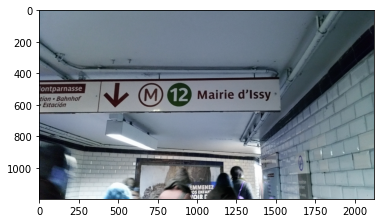

In [126]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
img_dir = "../BD_METRO"
img_name = "IM (1).JPG"
img_path = os.path.join(img_dir, img_name)
img = cv2.imread(img_path)
plt.imshow(img)
print(img.dtype)

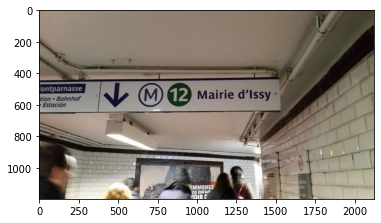

In [127]:
img_rgb = cv2.cvtColor((img).astype(np.uint8), cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)


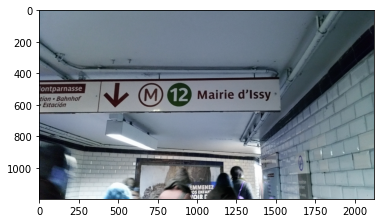

In [129]:
img_bgr = cv2.cvtColor((img_rgb).astype(np.uint8), cv2.COLOR_RGB2BGR)
plt.imshow(img_bgr)

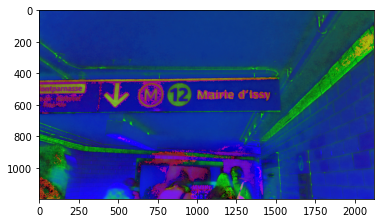

In [130]:
img_hsv = cv2.cvtColor((img_bgr).astype(np.uint8), cv2.COLOR_BGR2HSV)
plt.imshow(img_hsv)

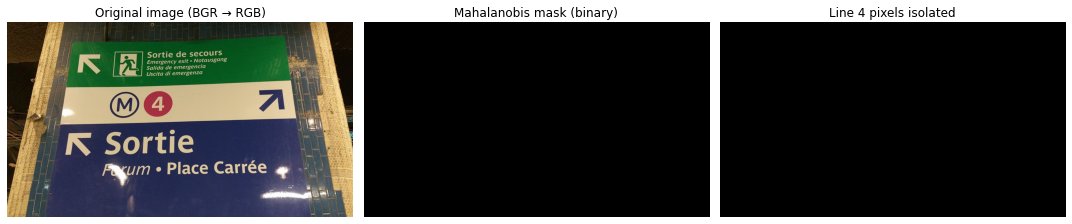

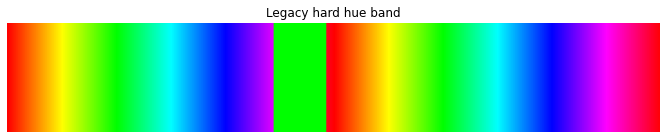

In [31]:
"""
Demo: Mahalanobis-distance colour search for Paris Metro line 4 symbol
----------------------------------------------------------------------
Replaces the hard HSV threshold (cv2.inRange) in your original
visualisation script with a *probabilistic* mask based on per-channel
(μ,σ) statistics.

核心关键词 / Mots-clés :
    Mahalanobis distance / distance de Mahalanobis
    HSV wrap-around / circularité de la teinte (Hue)
    Probability mask / masque probabiliste
"""

import json
from pathlib import Path
from typing import Tuple

import cv2
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------------------------------------------------
# 1 │ 读取参数 & 图像
# ----------------------------------------------------------------------
json_path = Path("../models/params.json")
with json_path.open("r") as f:
    params = json.load(f)

line_id = "4"  # 目标线路 -> Line 4
mean_hsv = np.array(params[line_id]["hsv_mean"], dtype=np.float32)
std_hsv = np.clip(np.array(params[line_id]["hsv_std"], dtype=np.float32), 5, None)

# ▶ 替换为你的测试图像路径
img_bgr = cv2.imread("../BD_METRO/IM (3).JPG")
assert img_bgr is not None, "Image not found."

hsv_img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

# ----------------------------------------------------------------------
# 2 │ Mahalanobis-distance mask
# ----------------------------------------------------------------------

def mahalanobis_mask(hsv: np.ndarray,
                      mu: np.ndarray,
                      sigma: np.ndarray,
                      threshold: float = 3.0) -> np.ndarray:
    """Return binary mask where Mahalanobis distance < threshold.

    hsv     : H,S,V uint8 image (H ∈ [0,179])
    mu/sigma: per-channel stats (shape: 3,)
    threshold: acceptance radius in σ-units
    """
    # Hue 环绕距离 / Distance circulaire sur la teinte
    dh = np.abs(hsv[:, :, 0].astype(np.float32) - mu[0])
    dh = np.minimum(dh, 180.0 - dh)

    ds = hsv[:, :, 1].astype(np.float32) - mu[1]
    dv = hsv[:, :, 2].astype(np.float32) - mu[2]

    dist = np.sqrt((dh / sigma[0])**2 + (ds / sigma[1])**2 + (dv / sigma[2])**2)
    mask = (dist < threshold).astype(np.uint8) * 255
    mask = cv2.medianBlur(mask, 5)  # 去噪 / anti-bruit
    return mask

mask_maha = mahalanobis_mask(hsv_img, mean_hsv, std_hsv, threshold=3.0)

# ----------------------------------------------------------------------
# 3 │ 可视化 (Original vs. Mahalanobis mask vs. Colour extraction)
# ----------------------------------------------------------------------
line4_pix = cv2.bitwise_and(img_bgr, img_bgr, mask=mask_maha)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
axes[0].set_title("Original image (BGR → RGB)")
axes[0].axis("off")

axes[1].imshow(mask_maha, cmap="gray")
axes[1].set_title("Mahalanobis mask (binary)")
axes[1].axis("off")

axes[2].imshow(cv2.cvtColor(line4_pix, cv2.COLOR_BGR2RGB))
axes[2].set_title("Line 4 pixels isolated")
axes[2].axis("off")

plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------
# 4 │ HSV 范围可视化函数 (保持原样，可选)
# ----------------------------------------------------------------------

def visualize_hsv_hue_band(lower_bound: Tuple[int, int, int],
                           upper_bound: Tuple[int, int, int],
                           title: str = "HSV hue band") -> None:
    """Interactive hue-band helper (unchanged from your draft)"""
    height, width = 60, 360
    hsv_strip = np.zeros((height, width, 3), dtype=np.uint8)
    for x in range(width):
        hsv_strip[:, x, 0] = x % 180
        hsv_strip[:, x, 1] = 255
        hsv_strip[:, x, 2] = 255
    bgr_strip = cv2.cvtColor(hsv_strip, cv2.COLOR_HSV2BGR)

    # highlight band
    mask = np.zeros((height, width), dtype=np.uint8)
    h_low, h_up = lower_bound[0], upper_bound[0]
    if h_low <= h_up:
        mask[:, h_low:h_up+1] = 255
    else:  # wrap-around
        mask[:, :h_up+1] = 255
        mask[:, h_low:180] = 255

    highlight = bgr_strip.copy()
    highlight[mask == 255] = (0, 255, 0)

    plt.figure(figsize=(12, 2))
    plt.imshow(cv2.cvtColor(highlight, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

# → 调用示例（可注释掉）
visualize_hsv_hue_band(params[line_id]["hsv_lower"],
                        params[line_id]["hsv_upper"],
                        title="Legacy hard hue band")


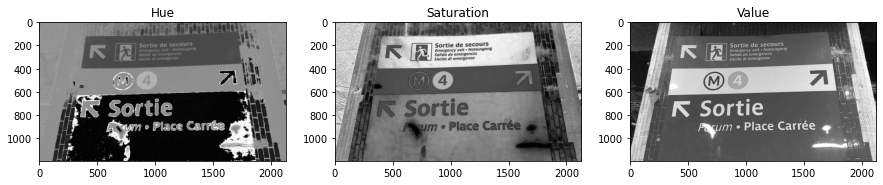

In [29]:

h, s, v = cv2.split(hsv)
plt.figure(figsize=(15, 5))
plt.subplot(131), plt.imshow(h, cmap='gray'), plt.title('Hue')
plt.subplot(132), plt.imshow(s, cmap='gray'), plt.title('Saturation')
plt.subplot(133), plt.imshow(v, cmap='gray'), plt.title('Value')
plt.show()

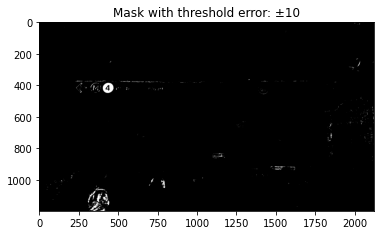

In [150]:
img_bgr = cv2.imread("../BD_METRO/IM (2).JPG")
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
json_path = Path("../models/color_params.json")
with json_path.open("r") as f:
    params = json.load(f)

line_id = "4"  
mean_hsv = np.array(params[line_id]["hsv_mean"], dtype=np.float64)
std_hsv = np.clip(np.array(params[line_id]["hsv_std"], dtype=np.float64), 5, None)

# 添加阈值误差
threshold_error = 10  # 阈值误差范围
hsv_lower = np.array(params[line_id]["hsv_lower"], dtype=np.float64)
hsv_upper = np.array(params[line_id]["hsv_upper"], dtype=np.float64)

# 应用阈值误差，确保值在有效范围内
hsv_lower_with_error = np.maximum(0, hsv_lower - threshold_error)
hsv_upper_with_error = np.minimum(np.array([179, 255, 255]), hsv_upper + threshold_error)

# 使用带误差的阈值创建掩码
mask = cv2.inRange(img_hsv, hsv_lower_with_error, hsv_upper_with_error)
#result = cv2.bitwise_and(img_bgr, img_bgr, mask=mask)

plt.imshow(mask, cmap='gray')
plt.title(f"Mask with threshold error: ±{threshold_error}")
plt.show()

[   3  426  582  838 1020    4]


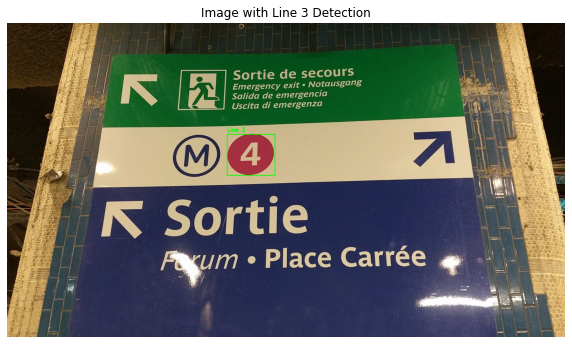

In [15]:
img_3 = mat_data['BD'][0]
print(img_3)
id_line = img_3[0]
y1 = img_3[1]
y2 = img_3[2]
x1 = img_3[3]
x2 = img_3[4]

bbox = (x1, y1, x2, y2)

img_dir = "../BD_METRO"
img_name = "IM (3).JPG"
img_path = os.path.join(img_dir, img_name)
img = cv2.imread(img_path)

# 在原始图片上绘制边界框
img_with_box = img.copy()  # 创建图像副本以免修改原图
color = (0, 255, 0)  # 绿色边框 (BGR格式)
thickness = 2  # 线条粗细
cv2.rectangle(img_with_box, (int(x1), int(y1)), (int(x2), int(y2)), color, thickness)

# 添加线路ID标签
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(img_with_box, f"Line {int(id_line)}", (int(x1), int(y1)-10), 
            font, 0.7, color, 2)

# 转换BGR到RGB用于matplotlib显示
img_rgb = cv2.cvtColor(img_with_box, cv2.COLOR_BGR2RGB)

# 显示带有边界框的图像
plt.figure(figsize=(10, 8))
plt.imshow(img_rgb)
plt.axis('off')
plt.title(f"Image with Line {int(id_line)} Detection")
plt.show()

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from typing import Tuple, Dict, List
import os

import cv2
import numpy as np
from typing import Tuple

def extract_dominant_hsv(
    roi_hsv: np.ndarray,
    K: int = 3,
    attempts: int = 10
) -> Tuple[int, int, int]:
    """
    从单个 ROI 的 HSV 像素中提取主峰色 (dominant HSV color / couleur HSV dominante)。

    Args:
        roi_hsv: ROI 在 HSV 空间的像素 (h, w, 3)
        K: 聚类簇数量 (clusters)
        attempts: kmeans 重启次数，选取最佳质心

    Returns:
        hsv_dominant: 三元组 (H, S, V)，代表主峰色
    """
    # 1. 准备样本 (Prepare samples / Préparer échantillons)
    pixels = roi_hsv.reshape(-1, 3).astype(np.float32)  # N × 3

    # 2. 定义 KMeans 终止条件 (KMeans criteria)
    criteria = (
        cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,
        100,    # 最多迭代次数 (max iterations)
        0.2     # 误差阈值 (epsilon)
    )

    # 3. 执行 K-Means 聚类
    ret, labels, centers = cv2.kmeans(
        pixels,
        K,
        None,
        criteria,
        attempts,
        flags=cv2.KMEANS_PP_CENTERS
    )
    # centers: shape (K, 3), dtype float32

    # 4. 统计每个簇的样本数 (Count cluster sizes / Taille des clusters)
    _, counts = np.unique(labels, return_counts=True)

    # 5. 选择主峰簇 (Select dominant cluster / Sélection du cluster dominant)
    dominant_idx = np.argmax(counts)
    dominant_center = centers[dominant_idx]  # HSV 坐标

    # 6. 返回整数化的 HSV 三元组
    return tuple(map(int, dominant_center))


def extract_metro_line_colors(mat_file_path, images_dir):
    """
    从训练数据中提取每条地铁线路的主要HSV颜色
    
    Args:
        mat_file_path: .mat文件路径
        images_dir: 图像目录
        
    Returns:
        line_colors: 每条线路的主要HSV颜色字典
    """
    # 加载.mat文件
    mat_data = sio.loadmat(mat_file_path)
    bd = mat_data['BD']
    
    # 存储每条线路的颜色样本
    line_colors_samples = {}
    
    # 遍历所有标注
    for i in range(bd.shape[0]):
        annotation = bd[i]
        img_id = int(annotation[0])
        y1, y2, x1, x2 = [int(coord) for coord in annotation[1:5]]  # 注意坐标顺序
        line_id = int(annotation[5])
        
        # 构建图像文件名
        img_name = f"IM ({img_id}).JPG"
        img_path = os.path.join(images_dir, img_name)
        
        # 检查文件是否存在
        if not os.path.exists(img_path):
            print(f"Warning: Image {img_path} not found, skipping...")
            continue
        
        # 加载图像
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Failed to load {img_path}, skipping...")
            continue
        
        # 提取ROI区域
        roi = img[y1:y2, x1:x2]
        
        # 转换到HSV颜色空间
        roi_hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
        
        # 提取主要颜色
        try:
            dominant_hsv = extract_dominant_hsv(roi_hsv, K=3)
            
            # 将颜色样本添加到对应线路
            if line_id not in line_colors_samples:
                line_colors_samples[line_id] = []
            line_colors_samples[line_id].append(dominant_hsv)
            
            # 可视化（可选）
            visualize_dominant_color(img, roi, dominant_hsv, line_id, x1, y1, x2, y2)
        except Exception as e:
            print(f"Error processing ROI from image {img_path}, line {line_id}: {e}")
        break
    
    # 计算每条线路的平均颜色
    line_colors = {}
    for line_id, samples in line_colors_samples.items():
        if not samples:
            continue
        
        # 将样本转换为numpy数组以便计算
        samples_array = np.array(samples)
        
        # 处理色调H通道的循环特性
        h_values = samples_array[:, 0]
        if np.max(h_values) - np.min(h_values) > 90:
            # 跨越0/180边界的情况
            h_values_adjusted = h_values.copy()
            if np.median(h_values) < 90:
                h_values_adjusted[h_values > 90] -= 180
            else:
                h_values_adjusted[h_values < 90] += 180
            
            avg_h = np.mean(h_values_adjusted)
            if avg_h < 0:
                avg_h += 180
            elif avg_h > 180:
                avg_h -= 180
        else:
            avg_h = np.mean(h_values)
        
        # 计算S和V的平均值
        avg_s = np.mean(samples_array[:, 1])
        avg_v = np.mean(samples_array[:, 2])
        
        # 计算HSV的标准差，用于设置范围
        std_h = np.std(h_values)
        std_s = np.std(samples_array[:, 1])
        std_v = np.std(samples_array[:, 2])
        
        # 存储颜色参数
        line_colors[str(line_id)] = {
            "hsv_mean": (int(avg_h), int(avg_s), int(avg_v)),
            "hsv_std": (int(std_h), int(std_s), int(std_v)),
            "hsv_lower": [max(0, int(avg_h - 2 * std_h)), 
                          max(0, int(avg_s - 2 * std_s)), 
                          max(0, int(avg_v - 2 * std_v))],
            "hsv_upper": [min(180, int(avg_h + 2 * std_h)), 
                          min(255, int(avg_s + 2 * std_s)), 
                          min(255, int(avg_v + 2 * std_v))]
        }
    
    return line_colors

# 可视化函数
def visualize_dominant_color(img, roi, hsv_color, line_id, x1, y1, x2, y2):
    """
    可视化主要颜色检测结果
    """
    # 创建展示图像
    plt.figure(figsize=(15, 5))
    
    # 显示原始图像和ROI框
    plt.subplot(1, 3, 1)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                                    edgecolor='g', facecolor='none', linewidth=2))
    plt.title(f"Original Image with Line {line_id} ROI")
    
    # 显示ROI区域
    plt.subplot(1, 3, 2)
    roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
    plt.imshow(roi_rgb)
    plt.title(f"ROI of Line {line_id}")
    
    # 显示提取的主要颜色
    plt.subplot(1, 3, 3)
    color_patch = np.ones((100, 100, 3), dtype=np.uint8)
    h, s, v = hsv_color
    # 将HSV颜色转换回BGR
    color_patch_hsv = np.full((100, 100, 3), (h, s, v), dtype=np.uint8)
    color_patch = cv2.cvtColor(color_patch_hsv, cv2.COLOR_HSV2BGR)
    color_patch_rgb = cv2.cvtColor(color_patch, cv2.COLOR_BGR2RGB)
    plt.imshow(color_patch_rgb)
    plt.title(f"Dominant Color\nHSV: ({h}, {s}, {v})")
    
    plt.tight_layout()
    plt.show()



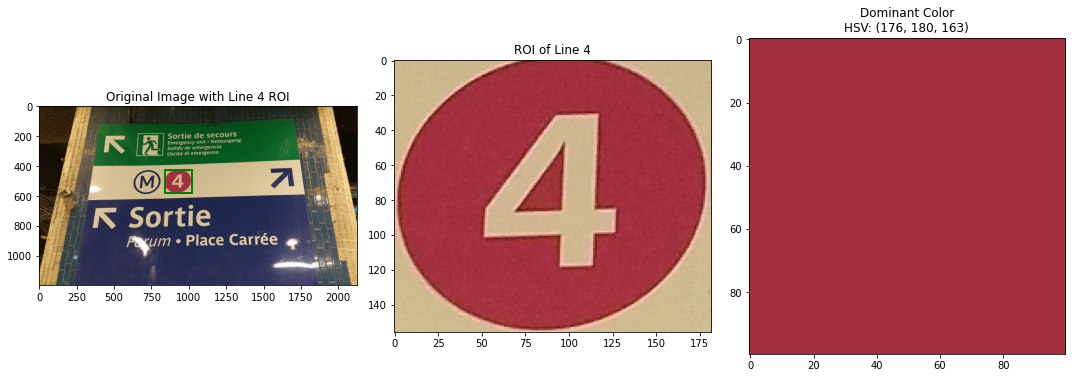

Line 4: Mean HSV = (176, 180, 163)
        HSV range: [176, 180, 163] to [176, 180, 163]


In [27]:

mat_file_path = "../BD_METRO/Apprentissage.mat"  # 训练数据
images_dir = "../BD_METRO"  # 图像目录


line_colors = extract_metro_line_colors(mat_file_path, images_dir)

# 打印结果
for line_id, color_params in line_colors.items():
    print(f"Line {line_id}: Mean HSV = {color_params['hsv_mean']}")
    print(f"        HSV range: {color_params['hsv_lower']} to {color_params['hsv_upper']}")
